In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

### Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [1]:
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

NameError: ignored

In [ ]:
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [ ]:
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [ ]:
# task: preprocess each comment in train and test

texts_train = [preprocess(x) for x in texts_train]
texts_test = [preprocess(x) for x in texts_test]

In [ ]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [1]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = 10000

totallist = list()
for i in range(len(texts_train)):
  totallist.extend(tokenizer.tokenize(texts_train[i]))

count = Counter(totallist)

bow_vocabulary = list({k : v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}.keys())[:k]

print('example features:', bow_vocabulary[::100])

NameError: ignored

In [ ]:
bow_vocabulary[:10]

In [ ]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    tokenized = tokenizer.tokenize(text)
    counts = Counter(tokenized)

    countscheck = counts.copy()
    for i in countscheck.keys():
      if i not in bow_vocabulary:
        del counts[i]

    dictvocab = dict()
    for i in bow_vocabulary:
      dictvocab[i] = 0

    tokencounts = (dictvocab | counts).values()

    return np.array(list(tokencounts))

In [ ]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [ ]:
k_max = len(count)
pk_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [ ]:
bow_model = LogisticRegression().fit(X_train_bow, y_train)

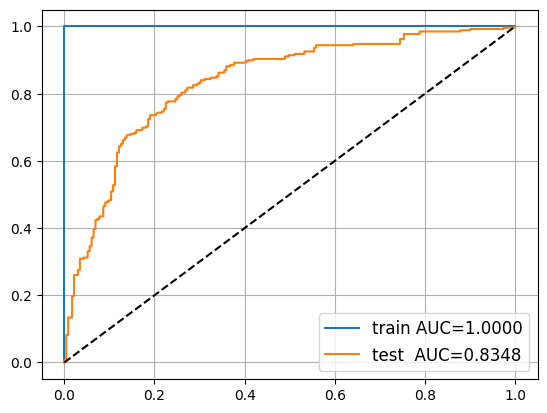

In [ ]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [ ]:
import gensim.downloader
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

# If you're low on RAM or download speed, use "glove-wiki-gigaword-100" instead. Ignore all further asserts.

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
embeddings.vectors

array([[ 0.020344 , -0.012294 , -0.0075729, ..., -0.01543  ,  0.030603 ,
         0.0047477],
       [ 0.024249 ,  0.0048235,  0.018411 , ..., -0.03496  ,  0.018361 ,
         0.0034856],
       [ 0.0048517, -0.0029997,  0.067174 , ..., -0.045819 , -0.011499 ,
         0.0011429],
       ...,
       [-0.0054115,  0.010333 ,  0.0093201, ...,  0.011071 ,  0.020105 ,
         0.009438 ],
       [-0.03419  , -0.01587  , -0.032591 , ..., -0.0076392, -0.023507 ,
         0.0224   ],
       [ 0.036409 ,  0.018222 , -0.0025157, ..., -0.0063276,  0.0009496,
         0.048746 ]], dtype=float32)

In [ ]:
embedding_dim = embeddings.vectors.shape[1]
embedding_dim

300

In [ ]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    tokenizer = TweetTokenizer()
    tokenized = tokenizer.tokenize(comment)
    for i in tokenized:
      try:
        features += embeddings.get_vector(i)
      except KeyError:
        pass

    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [ ]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

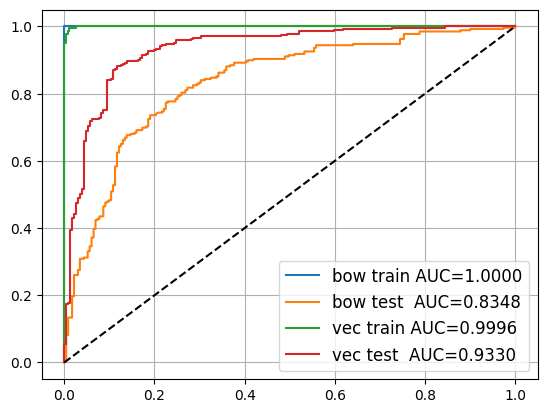

In [ ]:
wv_model = LogisticRegression(max_iter=100000).fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.